In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold,GroupKFold,StratifiedKFold
import copy
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score,log_loss
from sklearn.metrics import roc_curve ,precision_recall_curve
from sklearn.metrics import f1_score
import random
import gc

%matplotlib inline

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)               
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)              
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
#df = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/train.csv'))
#df_test = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/fraudremove/test.csv'))
df_sortprob = reduce_mem_usage(pd.read_csv('df_sortprob_23_no_test.csv'))
df = reduce_mem_usage(pd.read_csv('train.csv'))
df_test = reduce_mem_usage(pd.read_csv('test.csv'))

Memory usage of dataframe is 267.04 MB
Memory usage after optimization is: 63.86 MB
Decreased by 76.1%
Memory usage of dataframe is 267.04 MB
Memory usage after optimization is: 60.95 MB
Decreased by 77.2%
Memory usage of dataframe is 70.78 MB
Memory usage after optimization is: 16.49 MB
Decreased by 76.7%


In [4]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [5]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [6]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

In [7]:
# LABEL ENCODE
def encode_LE(cat_cols,train,test):
    for col in cat_cols:
        if col in train.columns:
            le = LabelEncoder()
            le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
            train[col] = le.transform(list(train[col].astype(str).values))
            test[col] = le.transform(list(test[col].astype(str).values))      

In [8]:
def group_ag(main_columns, uids,train_df, test_df, aggregations=['mean'],  
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-100,inplace=True)
                    test_df[new_col_name].fillna(-100,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')

In [9]:
def fillna(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )
    df1[col]=df1[col].fillna(-100)
    df2[col]=df2[col].fillna(-100)     
    print(df1[col].value_counts(dropna=False, normalize=True).head())     

In [10]:
def fillNY(df1,df2,col):
    df1[col] = df1[col].map( {'Y': 1, 'N': 0} )
    df2[col] = df2[col].map( {'Y': 1, 'N': 0} )   
    print(df1[col].value_counts(dropna=False, normalize=True).head())      

In [11]:
# COMBINE FEATURES
def encode_CB(col1,col2,df1,df2):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    le = LabelEncoder()
    le.fit(list(df[nm].astype(str).values) + list(df_test[nm].astype(str).values))
    df[nm] = le.transform(list(df[nm].astype(str).values))
    df_test[nm] = le.transform(list(df_test[nm].astype(str).values))
    print(nm,', ',end='')

In [12]:
big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols.remove('fraud_ind')
big_top_value_cols.remove('stscd')
big_top_value_cols.remove('iterm')
big_top_value_cols.remove('hcefg')
big_top_value_cols.remove('contp')
big_top_value_cols

['flbmk', 'flg_3dsmk', 'insfg', 'ovrlt']

In [13]:
#not use label encoding
fillNY(df,df_test,'insfg')
fillNY(df,df_test,'ovrlt')
fillNY(df,df_test,'ecfg')
fillna(df,df_test,'flbmk')
fillna(df,df_test,'flg_3dsmk')

0    0.972196
1    0.027804
Name: insfg, dtype: float64
0    0.986693
1    0.013307
Name: ovrlt, dtype: float64
0    0.745513
1    0.254487
Name: ecfg, dtype: float64
 0.0      0.988399
-100.0    0.008267
 1.0      0.003334
Name: flbmk, dtype: float64
 0.0      0.949454
 1.0      0.042279
-100.0    0.008267
Name: flg_3dsmk, dtype: float64


In [ ]:
#use label encoding
fillna(df,df_test,'flbmk')
fillna(df,df_test,'flg_3dsmk')
cat_cols =  list(df.columns)
cat_cols.remove('fraud_ind')
cat_cols.remove('flbmk')
cat_cols.remove('flg_3dsmk')
cat_cols.remove('txkey')
cat_cols.remove('loctm')
cat_cols.remove('locdt')
cat_cols.remove('conam')
encode_LE(cat_cols,df,df_test)
df['flg_3dsmk'].value_counts(dropna=False, normalize=True).head()

In [14]:
def change_time(data):
    time = data['loctm']
    hour = []
    minute = []
    second = []
    for i in time:        
        h = int(i/10000)
        m = int(i%10000/100)
        s = int(i%100)
        hour.append(h)
        minute.append(m)
        second.append(s)
    data['loctm_hour'] = hour
    data['loctm_min'] = minute
    data['loctm_s'] = second

In [15]:
def money_process(data):
    log =[]
    sqrt =[]
    for i in data['conam']:
        if(i==0):
            sqrt.append(i)
            log.append(i) 
        else:
            l = np.log(i)
            s = np.sqrt(i)
            sqrt.append(s)
            log.append(l)
    #data['conam_log'] = log
    data['conam_sqrt'] = sqrt  
    print('conam_sqrt',', ',end='')
#money_process(df)
#money_process(df_test)
#print(df['conam_log'].head())

In [16]:
change_time(df_sortprob)
change_time(df)
change_time(df_test)
import copy
df_sortprob=df_sortprob.drop(big_top_value_cols, axis=1)
df=df.drop(big_top_value_cols, axis=1)
df_test=df_test.drop(big_top_value_cols, axis=1)
df_backup = copy.copy(df_sortprob)
df_test_backup = copy.copy(df_test)
print(df.columns)
print(df.shape)

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'hcefg', 'iterm', 'locdt', 'loctm', 'mcc', 'mchno',
       'scity', 'stocn', 'stscd', 'txkey', 'loctm_hour', 'loctm_min',
       'loctm_s'],
      dtype='object')
(1521787, 22)


In [17]:
gc.collect()
import warnings
warnings.filterwarnings("ignore")

In [18]:
# PR 曲线对比
def show_pr():
        l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
        pr,re,t = precision_recall_curve(y_valid_df,pred)
        plt.plot(l_pr,l_re,color='red',label='last best')
        plt.plot(pr,re,color='green',label="now")
        plt.legend()
        plt.show()

## 從這裡開始

In [44]:
    params = {'max_depth': 47,
              #'gamma': 0.15626466439591735,            
              'learning_rate':0.02,
              #'min_child_weight':1.5233399970515784, 
              'colsample_bytree':0.4,
              'subsample':0.8,
              #'reg_alpha':4.989195734088519,
              #'reg_lambda':4.292050649851185,
              'scale_pos_weight':73.76231884057971,
              'max_delta_step ':0,
              #'eta': 0.1,
              'missing' : -100,
              'objective' :'binary:logistic',
               # USE CPU
               #'nthread' :1,
              #tree_method='hist'
               # USE GPU
              'gpu_id':'0',
              'tree_method':'gpu_hist',
              'eval_metric': 'logloss',
             #'seed':seed,
            # 'random_state ':seed,
             # 'shuffle':False,
             }

In [19]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)
print(df.shape[1])
print(df_test.shape[1])
print(df.columns)
print(df_test.columns)

22
21
Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'fraud_ind', 'hcefg', 'iterm', 'locdt', 'loctm', 'mcc', 'mchno',
       'scity', 'stocn', 'stscd', 'txkey', 'loctm_hour', 'loctm_min',
       'loctm_s'],
      dtype='object')
Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'hcefg', 'iterm', 'locdt', 'loctm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'txkey', 'loctm_hour', 'loctm_min', 'loctm_s'],
      dtype='object')


In [457]:
count_features = ['acqic', 'bacno', 'cano', 'iterm', 'mcc', 'stocn',
       'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]

encode_FE(df,df_test,count_features)
cf =  ['acqic_FE', 'bacno_FE', 'cano_FE', 'iterm_FE','stocn_scity_FE','mcc_mchno_FE' ]

['acqic', 'bacno', 'cano', 'conam', 'csmcu', 'ecfg', 'etymd', 'mcc', 'mchno', 'scity', 'stocn', 'stscd', 'loctm_hour', 'stocn_scity']


In [384]:
col1s = ['acqic', 'conam', 'ecfg', 'etymd', 'mcc',
       'mchno', 'scity', 'stocn', 'stscd', 'loctm_hour', 'stocn_scity','mcc_mchno']
for col in col1s:      
    group_ag([col],['cano'],df,df_test,['mean','std'])
    
#show_cor(df)

'acqic_bacno_cano_mean' , 'acqic_bacno_cano_std' , 'conam_bacno_cano_mean' , 'conam_bacno_cano_std' , 'ecfg_bacno_cano_mean' , 'ecfg_bacno_cano_std' , 'etymd_bacno_cano_mean' , 'etymd_bacno_cano_std' , 'mcc_bacno_cano_mean' , 'mcc_bacno_cano_std' , 'mchno_bacno_cano_mean' , 'mchno_bacno_cano_std' , 'scity_bacno_cano_mean' , 'scity_bacno_cano_std' , 'stocn_bacno_cano_mean' , 'stocn_bacno_cano_std' , 'stscd_bacno_cano_mean' , 'stscd_bacno_cano_std' , 'loctm_hour_bacno_cano_mean' , 'loctm_hour_bacno_cano_std' , 'stocn_scity_bacno_cano_mean' , 'stocn_scity_bacno_cano_std' , 

In [ ]:
gf = ['acqic__cano_mcc_mchno_mean' , 'acqic__cano_mcc_mchno_std' , 'conam__cano_mcc_mchno_mean' , 
       'conam__cano_mcc_mchno_std' , 'ecfg__cano_mcc_mchno_mean' , 'ecfg__cano_mcc_mchno_std' , 
       'etymd__cano_mcc_mchno_mean' , 'etymd__cano_mcc_mchno_std' , 'mcc__cano_mcc_mchno_mean' , 
       'mcc__cano_mcc_mchno_std' , 'mchno__cano_mcc_mchno_mean' , 'mchno__cano_mcc_mchno_std' , 
       'scity__cano_mcc_mchno_mean' , 'scity__cano_mcc_mchno_std' , 'stocn__cano_mcc_mchno_mean' , 
       'stocn__cano_mcc_mchno_std' , 'stscd__cano_mcc_mchno_mean' , 'stscd__cano_mcc_mchno_std' , 
       'loctm_hour__cano_mcc_mchno_mean' , 'loctm_hour__cano_mcc_mchno_std' , 'stocn_scity__cano_mcc_mchno_mean' ,
       'stocn_scity__cano_mcc_mchno_std' , 'mcc_mchno__cano_mcc_mchno_mean' , 'mcc_mchno__cano_mcc_mchno_std' , ]

In [ ]:
show_cor(df[gf])

In [ ]:
re_gf =['etymd_cano_std' ,'stscd_cano_std' ,'loctm_hour_cano_std','mchno_cano_mean' , 'mchno_cano_std' ]

In [ ]:
gf = set(gf) -set(re_gf)

In [ ]:
col1s =['mchno', 'scity', 'stocn', 'stscd',
       'loctm_hour', 'stocn_scity']#'acqic','conam', 'contp', 'csmcu', 'ecfg', 'etymd',
     #  'hcefg', 'iterm', 'mcc', 
col2s = ['acqic', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'hcefg', 'iterm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd',
       'loctm_hour', 'stocn_scity']
for col1 in col1s:
    for col2 in col2s:
        encode_CB(col1,col2,df,df_test)   

In [ ]:
col1s =[ 'csmcu','acqic',  
        'iterm', 'mcc', 'mchno', 'scity', 'stocn',
       'loctm_hour', 'stocn_scity']#'stscd','ecfg', 'etymd','hcefg','conam', 'contp', 
col2s = ['acqic', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'hcefg', 'iterm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd',
       'loctm_hour', 'stocn_scity']
for col1 in col1s:
    for col2 in col2s:
        model1_features =['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'hcefg', 'iterm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'loctm_hour','stocn_scity']   
        #combine feature
        #model1_features.append(col1+'_'+col2)
        #count feature
        #model1_features.append(col1+'_FE')
        #group feature 
        #temp = set(model1_features+cf+gf+gf1)#- set(remove_f)
        #model1_features= list(temp)
        model1_features =model1_features+cf+gf
        model1_features.append(col1+'__'+col2+'_mean')
        #if(not(col1=='etymd' or col1=='stscd' or col1 =='loctm_hour')): 
        model1_features.append(col1+'__'+col2+'_std')         
        X_train = df[model1_features]
        Y_train = df['fraud_ind']      
        # 将概率最大的20%作为验证集
        df_validation_2 = df.iloc[int(0.8 * len(df)):, ]
        df_train_2 = df.iloc[:int(0.8 * len(df)), ]
        train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
        valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
        print()
        print('train_df.columns = ',train_df.columns)
        print('train_df.shape = ',train_df.shape)
        trn_data = xgb.DMatrix(train_df, label=y_train_df,missing=-100)
        val_data = xgb.DMatrix(valid_df, label=y_valid_df,missing=-100) 
        Dtrain_df = xgb.DMatrix(train_df,missing=-100)
        Dvalid_df = xgb.DMatrix(valid_df,missing=-100)
        DX_test = xgb.DMatrix(X_test,missing=-100)
        watchlist = [(trn_data,'train'),(val_data,'val')]
        model = xgb.train(params,
                    trn_data,
                    num_boost_round= 10000,
                    evals  =watchlist,             
                    verbose_eval=0,
                    early_stopping_rounds = 200
                     )   
        pred = model.predict(Dvalid_df)   
        now_auc = roc_auc_score(y_valid_df, pred)
        #print( "      auc = ", now_auc ) 
        pred_file_path = 'compare_xgb.csv'
        last_pred = np.array(pd.read_csv(pred_file_path))
        last_auc = roc_auc_score(y_valid_df, last_pred)
        #print( "last  auc = ", last_auc ) 
        
        threshold = 0.5
        y_pre = [int(item>threshold) for  item in pred]  
        last_y_pre = [int(item>threshold) for  item in last_pred] 
        now_f1= f1_score(y_valid_df, y_pre)
        last_f1 =f1_score(y_valid_df, last_y_pre)
        #print( "     f1 = ", now_f1)
        #print( "last f1 = ", last_f1)
        now_ap = average_precision_score(y_valid_df, pred);
        #print( "     average_precision = ",now_ap)
        last_ap =average_precision_score(y_valid_df, last_pred)
        #print( "last average_precision = ",last_ap)
        count=0
        if(now_ap>last_ap):
            count=count+1
            print('ap improve')            
        if(now_f1>last_f1):
            count=count+1
            print('f1 improve')          
        if(now_auc>last_auc):      
            count=count+1
            print('auc improve')            
        if(count>0 or now_ap>last_ap):
            show_pr()
            #print('-------------------------------------',col1+'_'+col2,'count=',count)
            #print('-------------------------------------',col1+'_FE','count=',count)
            print('-------------------------------------',col1+'_'+col2,'count=',count)  
        print('-------------------------------------------------------------------------')     
        del model ,trn_data,val_data,Dtrain_df,Dvalid_df
        gc.collect()
        gc.collect()
        #print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )

In [53]:
#新特徵
#money_process(df)
#money_process(df_test)
encode_CB('bacno','cano',df,df_test) 
encode_CB('mcc','mchno',df,df_test)
encode_CB('stocn','scity',df,df_test)
encode_CB('stscd','csmcu',df,df_test)
encode_CB('stscd','loctm_hour',df,df_test)
encode_CB('contp','mchno',df,df_test)
encode_CB('cano','mcc_mchno',df,df_test)
#------------------------------------
#encode_CB('cano','etymd',df,df_test)


bacno_cano , stocn_scity , mcc_mchno , 

18
Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'hcefg', 'iterm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd',
       'loctm_hour', 'stocn_scity', 'mcc_mchno'],
      dtype='object')


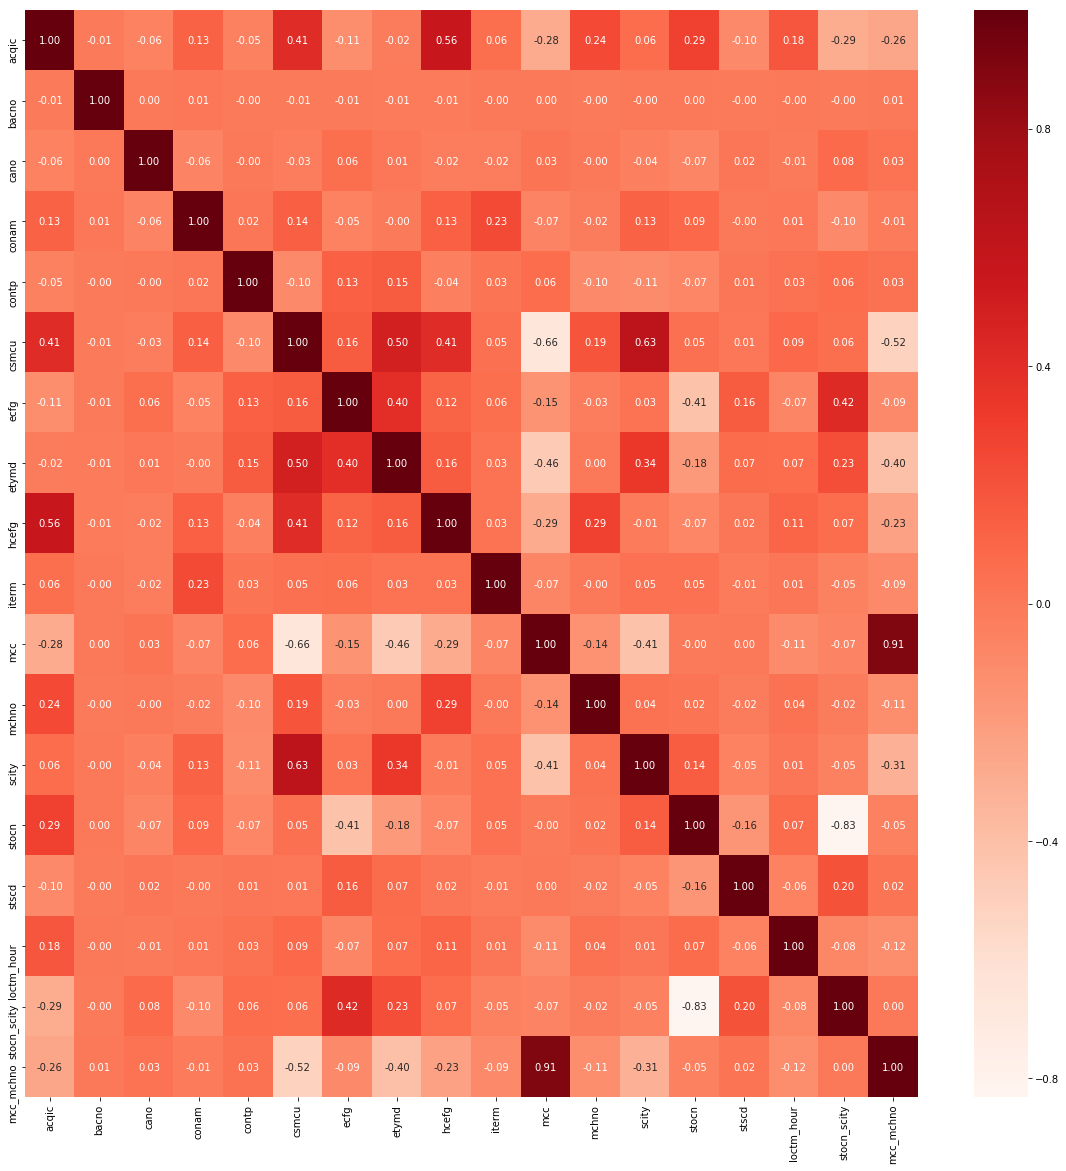

In [54]:
model1_features =['acqic', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'hcefg', 'iterm', 'mcc', 'mchno', 'scity', 'stocn',
       'stscd', 'loctm_hour','stocn_scity','mcc_mchno' ]            
#remove_f = ['contp','iterm','hcefg']
#temp = set(model1_features+cf+gf+gf1)#- set(remove_f)
model1_features= list(temp)
X_train = df[model1_features]
Y_train = df['fraud_ind']
X_test = df_test[model1_features]
#print(model1_features)
print(X_train.shape[1])
print(X_train.columns)
show_cor(df[model1_features])

In [55]:
# 将概率最大的20%作为验证集
df_validation_2 = df.iloc[int(0.8 * len(df)):, ]
df_train_2 = df.iloc[:int(0.8 * len(df)), ]

In [56]:
import time
predictions = np.zeros(len(X_test))

In [57]:
gc.collect()

15436

In [59]:
    #for i in range(2,11):
    #    params['max_delta_step ']=i;
    tStart = time.time()#計時開始
    train_df, y_train_df = df_train_2[model1_features], df_train_2['fraud_ind']
    valid_df, y_valid_df = df_validation_2[model1_features], df_validation_2['fraud_ind']
    print('train_df.columns = ',train_df.columns)
    print('train_df.shape = ',train_df.shape)
   
    trn_data = xgb.DMatrix(train_df, label=y_train_df,missing=-100)
    val_data = xgb.DMatrix(valid_df, label=y_valid_df,missing=-100) 
    Dtrain_df = xgb.DMatrix(train_df,missing=-100)
    Dvalid_df = xgb.DMatrix(valid_df,missing=-100)
    #DX_test = xgb.DMatrix(X_test,missing=-100)
    watchlist = [(trn_data,'train'),(val_data,'val')]
    model = xgb.train(params,
                    trn_data,
                    num_boost_round= 100000,
                    evals  =watchlist,             
                    verbose_eval=100,
                    early_stopping_rounds = 200
                     )   
    pred = model.predict(Dvalid_df)   
    print( "      auc = ", roc_auc_score(y_valid_df, pred) ) 
    pred_file_path = 'compare_xgb.csv'
    last_pred = np.array(pd.read_csv(pred_file_path))
    print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) ) 
    print("     log_loss = ",log_loss(y_valid_df, pred))
    print("last log_loss = ",log_loss(y_valid_df, last_pred))
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]  
    last_y_pre = [int(item>threshold) for  item in last_pred] 
    print( "     f1 = ", f1_score(y_valid_df, y_pre))
    print( "last f1 = ", f1_score(y_valid_df, last_y_pre))     
    print( "     average_precision = ",average_precision_score(y_valid_df, pred))
    print( "last average_precision = ",average_precision_score(y_valid_df, last_pred))

    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )    
    
    #del model ,trn_data,val_data,Dtrain_df,Dvalid_df
    #gc.collect()
    #gc.collect()
    print('_'*100)
    tEnd = time.time()#計時結束
    #列印結果
    print ("It cost %f sec" % (tEnd - tStart))#會自動做近位  
    

train_df.columns =  Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'hcefg', 'iterm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd',
       'loctm_hour', 'stocn_scity', 'mcc_mchno'],
      dtype='object')
train_df.shape =  (1217429, 18)
[0]	train-logloss:0.674295	val-logloss:0.674443
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.107941	val-logloss:0.113144
[200]	train-logloss:0.035749	val-logloss:0.043702
[300]	train-logloss:0.019934	val-logloss:0.029745
[400]	train-logloss:0.013568	val-logloss:0.024704
[500]	train-logloss:0.010109	val-logloss:0.022299
[600]	train-logloss:0.007786	val-logloss:0.020804
[700]	train-logloss:0.006382	val-logloss:0.020007
[800]	train-logloss:0.005436	val-logloss:0.019601
[900]	train-logloss:0.004727	val-logloss:0.019415
[1000]	train-logloss:0.004269	val-logloss:0.019386
[1100]	train-logloss:0.003832	val-

In [2]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(booster=model,max_num_features = 40, ax=ax)
plt.show()

NameError: name 'plt' is not defined

In [1]:
pred_file_path = 'compare_xgb.csv'
last_pred = np.array(pd.read_csv(pred_file_path))
print( "last  auc = ", roc_auc_score(y_valid_df, last_pred) )  
# ROC 曲线对比
l_fpr,l_tpr,l_t = roc_curve(y_valid_df,last_pred)
fpr,tpr,t = roc_curve(y_valid_df,pred)
plt.plot(l_fpr,l_tpr,color='red',label='last best')
plt.plot(fpr,tpr,color='green',label="now")
plt.legend()  

NameError: name 'np' is not defined

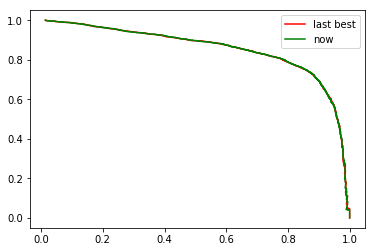

In [40]:
# PR 曲线对比
l_pr,l_re,l_t = precision_recall_curve(y_valid_df,last_pred)
pr,re,t = precision_recall_curve(y_valid_df,pred)
plt.plot(l_pr,l_re,color='red',label='last best')
plt.plot(pr,re,color='green',label="now")
plt.legend() 

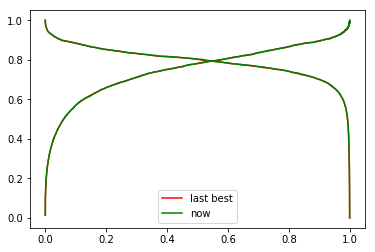

In [41]:
plt.plot(l_t,l_pr[:-1],color='red',label='last best')
plt.plot(l_t,l_re[:-1],color='red')
plt.legend() 
plt.plot(t,pr[:-1],color='green',label="now")
plt.plot(t,re[:-1],color='green')
plt.legend() 

## 是否将存为新指标

In [453]:
'''是否将存为新指标'''
print("save  file...")
last_pred = pd.DataFrame({'pred':pred})
last_pred.to_csv('compare_xgb.csv',index=None)

save  file...


In [ ]:
# 获取最佳 阈值方法 
def get_threshold(pre,rec,threshold):
    thold = []
    for i in range(len(threshold)):
        if round(pre[i],4)== round(rec[i],4):
            thold.append(threshold[i]) 
    return thold
pr,re,t = precision_recall_curve(Y_train,Y_valid)
#thold = get_threshold(pr,re,t)

## train start!

train feature  Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'hcefg', 'iterm', 'mcc', 'mchno', 'scity', 'stocn', 'stscd',
       'loctm_hour', 'stocn_scity'],
      dtype='object')
train shape  (1521787, 17)
____________________________________________________________________________________________________
Fold 0
[0]	train-logloss:0.674453	val-logloss:0.674657
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.117264	val-logloss:0.125756
[200]	train-logloss:0.043201	val-logloss:0.055518
[300]	train-logloss:0.022264	val-logloss:0.038034
[400]	train-logloss:0.014872	val-logloss:0.032967
[500]	train-logloss:0.010776	val-logloss:0.030772
[600]	train-logloss:0.008432	val-logloss:0.029999
[700]	train-logloss:0.007133	val-logloss:0.02988
[800]	train-logloss:0.006057	val-logloss:0.029928
Stopping. Best iteration:
[668]	train-logloss:0.007

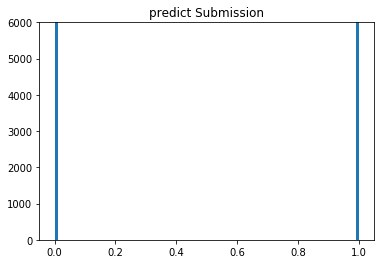

____________________________________________________________________________________________________
Fold 1
[0]	train-logloss:0.674456	val-logloss:0.674654
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.11633	val-logloss:0.124443
[200]	train-logloss:0.042775	val-logloss:0.05554
[300]	train-logloss:0.022019	val-logloss:0.038865
[400]	train-logloss:0.014707	val-logloss:0.034165
[500]	train-logloss:0.010625	val-logloss:0.032128
[600]	train-logloss:0.008292	val-logloss:0.031419
[700]	train-logloss:0.006993	val-logloss:0.031315
[800]	train-logloss:0.005936	val-logloss:0.031369
Stopping. Best iteration:
[673]	train-logloss:0.007287	val-logloss:0.031273

  auc =  0.9801009924618089
  f1 =  0.6403294691885296
  confusion_matrix = 
 [[498264   2084]
 [  2632   4198]]


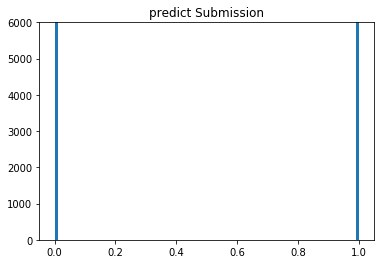

____________________________________________________________________________________________________
Fold 2
[0]	train-logloss:0.674475	val-logloss:0.674667
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 200 rounds.
[100]	train-logloss:0.118231	val-logloss:0.125528
[200]	train-logloss:0.044115	val-logloss:0.055814
[300]	train-logloss:0.022909	val-logloss:0.038417
[400]	train-logloss:0.015334	val-logloss:0.033297
[500]	train-logloss:0.011083	val-logloss:0.030901
[600]	train-logloss:0.00866	val-logloss:0.029954
[700]	train-logloss:0.007303	val-logloss:0.029736
[800]	train-logloss:0.006191	val-logloss:0.029676
[900]	train-logloss:0.005282	val-logloss:0.029756
Stopping. Best iteration:
[780]	train-logloss:0.0063	val-logloss:0.029633

  auc =  0.9835195650250652
  f1 =  0.635469543147208
  confusion_matrix = 
 [[498672   2141]
 [  2455   4006]]


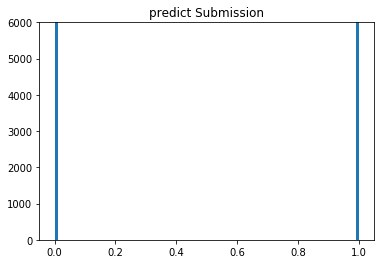

avg  auc =  0.9821556435434401
avg  f1 =  0.6415040004914196
oof  auc =  0.9821524507750735
oof  f1 =  0.6416424084571779
confusion_matrix =
[[1495189    6243]
 [   7791   12564]]
oof  average_precision =  0.6779563004737496


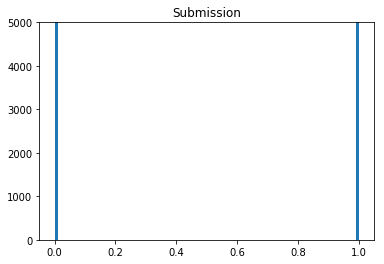

In [42]:
    tStart = time.time()#計時開始
    X_train = df[model1_features].copy()
    Y_train = df['fraud_ind'].copy()   
    splits = 3
    oof = np.zeros(len(X_train))
    folds = KFold(n_splits = splits)
    folds = GroupKFold(n_splits=splits)
    #folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
    split_groups = df['locdt'] #group
    #split_groups = df['fraud_ind'] #startifiedkfold   
    f1_avg = 0
    auc_avg = 0
    predictions = np.zeros(len(X_test))
    #print('remove feature =',col)
    print('train feature ',X_train.columns)
    print('train shape ',X_train.shape)
    #for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, Y_train.values)): #kfold
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train,groups=split_groups)): #groupkfold and startifiedfold
        print('_'*100)
    
        print("Fold {}".format(fold_))
        
        train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
        valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
        
        trn_data = xgb.DMatrix(train_df, label=y_train_df)
        val_data = xgb.DMatrix(valid_df, label=y_valid_df) 
        Dtrain_df = xgb.DMatrix(train_df)
        Dvalid_df = xgb.DMatrix(valid_df)
        DX_test = xgb.DMatrix(X_test)
        watchlist = [(trn_data,'train'),(val_data,'val')]        
       
        
        clf = xgb.train(params,
                    trn_data,
                    num_boost_round= 20000,
                    evals  =watchlist,             
                    verbose_eval=100,
                    early_stopping_rounds = 200
                     )   
        pred = clf.predict(Dvalid_df) 
        
        oof[val_idx] = pred      
    
        print( "  auc = ", roc_auc_score(y_valid_df, pred) )    
        threshold = 0.5
        y_pre = [int(item>threshold) for  item in pred]   
        print( "  f1 = ", f1_score(y_valid_df, y_pre))
        print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
        auc_avg+= roc_auc_score(y_valid_df, pred)
        f1_avg+=f1_score(y_valid_df, y_pre)       
        predictions += clf.predict(DX_test) / splits
        plt.hist(y_pre,bins=100)
        plt.ylim((0,6000))       
        plt.title('predict Submission')
        plt.show()
        gc.collect()       
print( "avg  auc = ", auc_avg/ splits )
print( "avg  f1 = ", f1_avg/ splits)
print( "oof  auc = ", roc_auc_score(Y_train, oof) )   
oof_threshold = [int(item>0.5) for  item in oof] 
print( "oof  f1 = ", f1_score(Y_train, oof_threshold))
print( "confusion_matrix =")
print(confusion_matrix(Y_train, oof_threshold))
average_precision = average_precision_score(Y_train, oof) 
print( "oof  average_precision = ",average_precision)
y_oof = [int(item>0.5) for  item in oof]   
plt.hist(y_oof,bins=100)
plt.ylim((0,5000))
plt.title('Submission')
plt.show() 
tEnd = time.time()#計時結束
#列印結果
print ("It cost %f sec" % (tEnd - tStart))#會自動做近位  

In [374]:
'''是否将存为新指标'''
print("save  file...")
last_pred = pd.DataFrame({'pred':oof})
last_pred.to_csv('compare_xgb_oof.csv',index=None)

save  file...


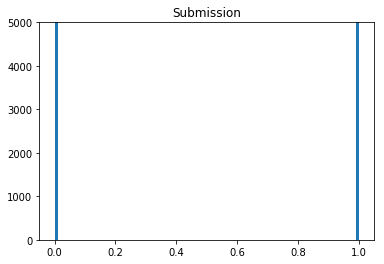

testdata = 421665
1.34% of testdata = 5650.0
fraud predict = 6083


In [375]:
# 结果保存
threshold =0.5
prediction = [int(item>threshold) for  item in predictions]
plt.hist(prediction,bins=100)
plt.ylim((0,5000))
plt.title('Submission')
plt.show()
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = prediction
sampleSubmission.to_csv('submission_test.csv',index = None)

print('testdata =',df_test['txkey'].count())
print('1.34% of testdata =',round(df_test['txkey'].count()*0.0134))
print('fraud predict =',sampleSubmission['fraud_ind'].value_counts()[1])